In [233]:
pwd

'/home/wsuser/work'

In [234]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [235]:
!pip install tensorflow

In [236]:
!pip install keras

In [237]:
pwd

'/home/wsuser/work'

In [238]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='HQ09AVokFQpYqTB_wkvPEwjyaDCXpn8BC_HLfaNOsiQ1',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoilpriceprediction-donotdelete-pr-yu4ambvs1gxbkc'
object_key = 'crude_oil_prices_daily.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()



,Date,Closing Value
0,02-01-1986,25.56
1,03-01-1986,26.00
2,06-01-1986,26.53
3,07-01-1986,25.85
4,08-01-1986,25.87


In [239]:
data.isnull().any()


Date             False
Closing Value     True
dtype: bool

In [240]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [241]:
data.dropna(axis=0,inplace=True)
data.isnull().sum()

Date             0
Closing Value    0
dtype: int64

In [242]:
data_oil=data.reset_index()['Closing Value']

In [243]:
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

In [244]:
from sklearn.preprocessing import MinMaxScaler
Scaler=MinMaxScaler(feature_range=(0,1))
data_oil=Scaler.fit_transform(np.array(data_oil).reshape(-1,1))

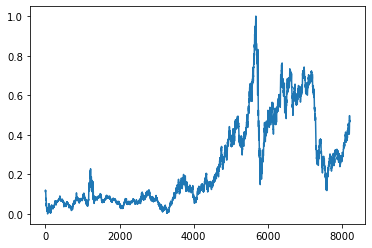

In [245]:
plt.plot(data_oil)

In [246]:
training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]

In [247]:
training_size,test_size

(5340, 2876)

In [248]:
train_data.shape

(5340, 1)

In [249]:
def create_dataset(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
        return np.array(dataX),np.array(dataY)

In [250]:
time_step=10
X_train,y_train=create_dataset(train_data,time_step)
X_test,y_test=create_dataset(test_data,time_step)


In [251]:
print(X_train.shape),print(y_train.shape)

(1, 10)
(1,)


(None, None)

In [252]:
X_train

array([[0.11335703, 0.11661484, 0.12053902, 0.11550422, 0.1156523 ,
        0.11683696, 0.1140234 , 0.10980305, 0.1089886 , 0.11054346]])

In [253]:
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)


# MODEL BUILDING

In [254]:
import tensorflow
import keras

In [255]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM


In [256]:
model=Sequential()

In [257]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

In [258]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_14 (LSTM)              (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [259]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [260]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 0.0100 - val_loss: 0.0958
Epoch 2/50
1/1 [==============================] - 0s 76ms/step - loss: 0.0062 - val_loss: 0.0759
Epoch 3/50
1/1 [==============================] - 0s 118ms/step - loss: 0.0032 - val_loss: 0.0567
Epoch 4/50
1/1 [==============================] - 0s 94ms/step - loss: 0.0010 - val_loss: 0.0389
Epoch 5/50
1/1 [==============================] - 0s 114ms/step - loss: 2.2645e-05 - val_loss: 0.0245
Epoch 6/50
1/1 [==============================] - 0s 137ms/step - loss: 4.8674e-04 - val_loss: 0.0172
Epoch 7/50
1/1 [==============================] - 0s 117ms/step - loss: 0.0015 - val_loss: 0.0160
Epoch 8/50
1/1 [==============================] - 0s 157ms/step - loss: 0.0018 - val_loss: 0.0183
Epoch 9/50
1/1 [==============================] - 0s 155ms/step - loss: 0.0014 - val_loss: 0.0228
Epoch 10/50
1/1 [==============================] - 0s 78ms/step - loss: 7.2699e-04 - val_loss: 0.0283
Epoch 11/50
1

In [261]:
from sklearn.model_selection import train_test_split

In [262]:
import tensorflow as tf
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [263]:
train_predict=Scaler.inverse_transform(train_predict)
test_predict=Scaler.inverse_transform(test_predict)

In [264]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

24.405587495317747

In [265]:
math.sqrt(mean_squared_error(y_test,test_predict))

29.508512022158808

In [266]:
from tensorflow.keras.models import load_model

In [267]:
model.save("crude_oil.h5")


In [294]:
!tar -zcvf crude_oil.tgz crude_oil.h5

crude_oil.h5


In [268]:
ls -1

crude_oil/
crude_oil.h5


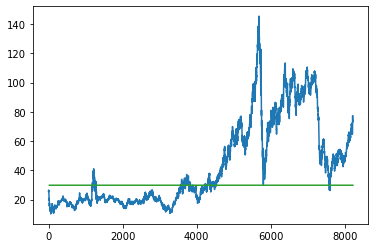

Green indicates predicted data
Blue indicates complete data
Orange indicates train data


In [269]:
look_back=10
trainPredictPlot=np.empty_like(data_oil)
trainPredictPlot[:,:]=np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:]=train_predict
testPredictPlot=np.empty_like(data_oil)
testPredictPlot[:,:]=np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_oil)-1,:]=test_predict
plt.plot(Scaler.inverse_transform(data_oil))
plt.plot(trainPredictPlot,label="traindata")
plt.plot(testPredictPlot,label="testdata")
plt.show()
print("Green indicates predicted data")
print("Blue indicates complete data")
print("Orange indicates train data")

In [270]:
len(test_data)

2876

In [271]:
X_input=test_data[2866:].reshape(1,-1)
X_input.shape

(1, 10)

In [272]:
temp_input=list(X_input)
temp_input=temp_input[0].tolist()


In [273]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [274]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):
        X_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,X_input))
        X_input=X_input.reshape(1,-1)
        X_input=X_input.reshape((1,n_steps,1))
        yhat=model.predict(X_input,verbose=0)
        print("{} day output {}.format(i,yhat)")
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        X_input=X_input.reshape((1,n_steps,1))
        yhat=model.predict(X_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.1600357]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.1600357 ]
{} day output {}.format(i,yhat)
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.1600357  0.15953723]
{} day output {}.format(i,yhat)
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.1600357  0.15953723 0.15704049]
{} day output {}.format(i,yhat)
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.1600357  0.15953723 0.15704049 0.15297493]
{} day output {}.format(i,yhat)
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.1600357
 0.15953723 0.15704049 0.15297493 0.1482878 ]
{} day output {}.format(i,yhat)
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.1600357  0.15953723
 0.15704049 0.15297493 0.1482878  0.14266656]
{} day output {}.format(i,yhat)
7 day input [0.46497853 0.47038353 0.4714941

In [275]:
day_new=np.arange(1,11)
day_pred=np.arange(11,21)

In [276]:
len(data_oil)

8216

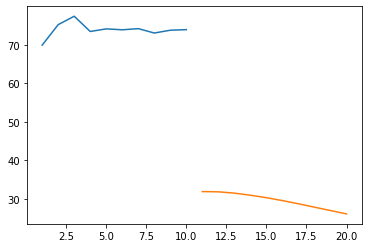

In [277]:
plt.plot(day_new,Scaler.inverse_transform(data_oil[8206:]))
plt.plot(day_pred,Scaler.inverse_transform(lst_output))


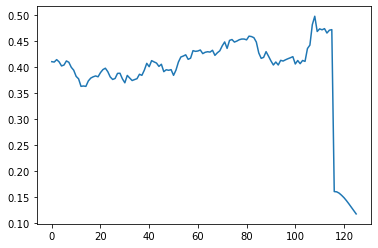

In [278]:
df3=data_oil.tolist()
df3.extend(lst_output)
plt.plot(df3[8100:])

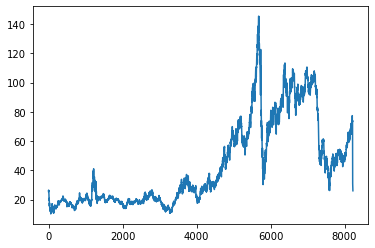

In [279]:
df3=Scaler.inverse_transform(df3).tolist()
plt.plot(df3)

In [280]:
!pip install ibm_watson_machine_learning

In [281]:
from ibm_watson_machine_learning import APIClient
wml_credentials={
                  "url": "https://us-south.ml.cloud.ibm.com",
                  "apikey":"ZcKrvOi0TIzCzB-WQ5kKulBWBLh1ofDJ3YZ0_882DqhZ"
                }
client=APIClient(wml_credentials)

In [282]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [283]:
space_uid=guid_from_space_name(client, 'models')
print('Space UID =' + space_uid)

Space UID =eca1ca24-a017-4416-9910-6890d9fcc6be


In [284]:
client.set.default_space(space_uid)

'SUCCESS'

In [296]:
client.software_specifications.list(100)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

In [298]:
software_spec_uid=client.software_specifications.get_uid_by_name("tensorflow_rt22.1-py3.9")
software_spec_uid

'acd9c798-6974-5d2f-a657-ce06e986df4d'

In [299]:
model_details=client.repository.store_model(model="crude_oil.tgz",meta_props={
client.repository.ModelMetaNames.NAME:"Crudeoil_prediction",
client.repository.ModelMetaNames.TYPE:"tensorflow_2.7",
client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid}
                                           )

model_id=client.repository.get_model_uid(model_details)

This method is deprecated, please use get_model_id()


In [300]:
model_id

'1b3bb617-294c-4662-9a5e-543eb543ecc8'

In [301]:
client.repository.download(model_id,'crude_oil.tar.gz')

Successfully saved model content to file: 'crude_oil.tar.gz'


'/home/wsuser/work/crude_oil.tar.gz'